In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
print(torch.__version__)

import torchvision
print(torchvision.__version__)
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torchvision import models

1.8.1
0.9.1


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [4]:
train_data_path='C:\\Users\\okngd\\leaf_disease_detection\\dataset\\train'

In [5]:
dataset = torchvision.datasets.ImageFolder(root=train_data_path,  
                                        transform=transform_train)

In [6]:
batch_size=8

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels)

torch.Size([8, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([ 9,  4,  2, 21,  9,  5, 18, 17])


In [9]:
len(dataloader)

3142

In [10]:

def imshow(img, title):
    
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction
    
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [11]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

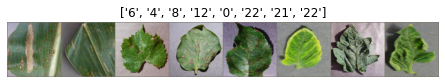

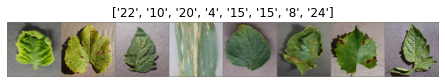

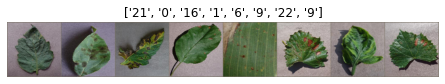

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


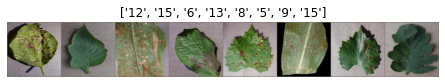

In [12]:
for i in range(4):
    show_batch_images(dataloader)

In [13]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
transform_test = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [14]:
train_data_path='C:\\Users\\okngd\\leaf_disease_detection\\dataset\\train'
test_data_path='C:\\Users\\okngd\\leaf_disease_detection\\dataset\\test'

In [15]:
batch_size=16

In [16]:
trainset = torchvision.datasets.ImageFolder(root=train_data_path,  
                                        transform=transform_train)
test_set = torchvision.datasets.ImageFolder(root=test_data_path,  
                                        transform=transform_test)

In [17]:
len(trainset)

25132

In [18]:
train_set, val_set = torch.utils.data.random_split(dataset, [20132, 5000])

In [19]:
len(train_set),len(val_set),len(test_set)

(20132, 5000, 6265)

In [20]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [21]:
num_classes = 25
classes=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
         'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight',
         'Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
         'Potato___Early_blight','Potato___healthy','Potato___Late_blight','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___healthy','Tomato___Late_blight',
         'Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
         'Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [22]:
resnet=models.resnet152(pretrained=True)

In [23]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
for param in resnet.parameters():
    param.requires_grad=False

In [25]:
in_features=resnet.fc.in_features
resnet.fc=nn.Sequential(nn.Linear(in_features,64),
                        torch.nn.Dropout(0.25),
                        nn.LeakyReLU(),
                        nn.Linear(64,25)
                       )

In [26]:

for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 2048])
torch.Size([64])
torch.Size([25, 64])
torch.Size([25])


In [27]:
num_epochs=30
learning_rate = 0.001

In [28]:
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(),lr=learning_rate)

In [29]:
def evaluation(dataloader,model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    return 100 * correct / total

In [30]:
def execute_training(num_epochs,model,loss_fn,optimizer,device,trainloader,valloader,
                     num_classes,batch_size,
                     train_set,val_set,plot_loss,plot_accuracy,plot_confusion_matrix):
    loss_epoch_train = []
    loss_epoch_val=[]
    train_acc=[]
    val_acc=[]
    confusion_matrix = np.zeros([num_classes, num_classes])
    for epoch in range(num_epochs):
        train_loss=0
        val_loss=0
        correct=0
        #Training Mode
        model.train()
        for i,batch in enumerate(trainloader):
            if i==0:
                print('Training Started............')
            if (i+1)%50==0:
                print(f'epoch ({epoch+1}/{num_epochs}), Batch ({i+1}/{np.ceil(len(train_set)/batch_size)})')
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            del inputs, targets, outputs
            torch.cuda.empty_cache()

        model.eval()
        if plot_loss:
            with torch.no_grad():
                #Calculating Training Loss
                for batch in trainloader:
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    targets = targets.to(device)
                    loss = loss_fn(outputs,targets)
                    train_loss+=loss.data.item()
                    del inputs, targets, outputs
                    torch.cuda.empty_cache()
                train_loss/=len(trainloader) #Loss per sample
                loss_epoch_train.append(train_loss)
                #calculating Validation Loss
                for batch in valloader:
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    targets = targets.to(device)
                    loss = loss_fn(outputs,targets)
                    if plot_confusion_matrix:
                        pred = outputs.data.max(1)[1]
                        correct += pred.eq(targets.data).sum().item()
                        for x, y in zip(pred.to('cpu').numpy(), targets.to('cpu').numpy()):
                                confusion_matrix[x][y] += 1
                    val_loss += loss.data.item()
                    del inputs, targets, outputs
                    torch.cuda.empty_cache()
                val_loss/=len(valloader)#Loss per sample
                loss_epoch_val.append(val_loss)
                
        if plot_accuracy:
            with torch.no_grad():
                print('calculating acc....')
                train_acc.append(evaluation(trainloader,model))
                val_acc.append(evaluation(valloader,model))
        print('epoch finished........')            
        print(f'epoch {epoch+1}/{num_epochs} , Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc[-1]},Val Acc: {val_acc[-1]}')
    if plot_loss:
        plt.plot(loss_epoch_train,c='blue',label='Train Loss')
        plt.plot(loss_epoch_val,c='red',label='Val Loss')
        plt.legend()
        plt.show()
    if plot_accuracy:
        plt.plot(train_acc,c='blue',label='Train Acc')
        plt.plot(val_acc,c='red',label='Val Acc')
        plt.legend()
        plt.show()
    if plot_confusion_matrix:
        classes = np.arange(num_classes)
        fig, ax = plt.subplots()
        im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                    yticks=np.arange(confusion_matrix.shape[0]),
                    xticklabels=classes, yticklabels=classes,
                    ylabel='True label',
                    xlabel='Predicted label',
                    title='Epoch %d' % (epoch+1))
        thresh = confusion_matrix.max() / 2.
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                ax.text(j, i, int(confusion_matrix[i, j]),
                        ha="center", va="center",
                        color="white" if confusion_matrix[i, j] > thresh else "black")

        fig.tight_layout()

Training Started............
epoch (1/30), Batch (50/1259.0)
epoch (1/30), Batch (100/1259.0)
epoch (1/30), Batch (150/1259.0)
epoch (1/30), Batch (200/1259.0)
epoch (1/30), Batch (250/1259.0)
epoch (1/30), Batch (300/1259.0)
epoch (1/30), Batch (350/1259.0)
epoch (1/30), Batch (400/1259.0)
epoch (1/30), Batch (450/1259.0)
epoch (1/30), Batch (500/1259.0)
epoch (1/30), Batch (550/1259.0)
epoch (1/30), Batch (600/1259.0)
epoch (1/30), Batch (650/1259.0)
epoch (1/30), Batch (700/1259.0)
epoch (1/30), Batch (750/1259.0)
epoch (1/30), Batch (800/1259.0)
epoch (1/30), Batch (850/1259.0)
epoch (1/30), Batch (900/1259.0)
epoch (1/30), Batch (950/1259.0)
epoch (1/30), Batch (1000/1259.0)
epoch (1/30), Batch (1050/1259.0)
epoch (1/30), Batch (1100/1259.0)
epoch (1/30), Batch (1150/1259.0)
epoch (1/30), Batch (1200/1259.0)
epoch (1/30), Batch (1250/1259.0)
calculating acc....
epoch finished........
epoch 1/30 , Train Loss: 0.39942277582085634, Val Loss: 0.3827458731949139, Train Acc: 88.69958275

epoch (9/30), Batch (50/1259.0)
epoch (9/30), Batch (100/1259.0)
epoch (9/30), Batch (150/1259.0)
epoch (9/30), Batch (200/1259.0)
epoch (9/30), Batch (250/1259.0)
epoch (9/30), Batch (300/1259.0)
epoch (9/30), Batch (350/1259.0)
epoch (9/30), Batch (400/1259.0)
epoch (9/30), Batch (450/1259.0)
epoch (9/30), Batch (500/1259.0)
epoch (9/30), Batch (550/1259.0)
epoch (9/30), Batch (600/1259.0)
epoch (9/30), Batch (650/1259.0)
epoch (9/30), Batch (700/1259.0)
epoch (9/30), Batch (750/1259.0)
epoch (9/30), Batch (800/1259.0)
epoch (9/30), Batch (850/1259.0)
epoch (9/30), Batch (900/1259.0)
epoch (9/30), Batch (950/1259.0)
epoch (9/30), Batch (1000/1259.0)
epoch (9/30), Batch (1050/1259.0)
epoch (9/30), Batch (1100/1259.0)
epoch (9/30), Batch (1150/1259.0)
epoch (9/30), Batch (1200/1259.0)
epoch (9/30), Batch (1250/1259.0)
calculating acc....
epoch finished........
epoch 9/30 , Train Loss: 0.13231335353843032, Val Loss: 0.17024140727197448, Train Acc: 95.35068547585932,Val Acc: 93.86
Traini

epoch (17/30), Batch (50/1259.0)
epoch (17/30), Batch (100/1259.0)
epoch (17/30), Batch (150/1259.0)
epoch (17/30), Batch (200/1259.0)
epoch (17/30), Batch (250/1259.0)
epoch (17/30), Batch (300/1259.0)
epoch (17/30), Batch (350/1259.0)
epoch (17/30), Batch (400/1259.0)
epoch (17/30), Batch (450/1259.0)
epoch (17/30), Batch (500/1259.0)
epoch (17/30), Batch (550/1259.0)
epoch (17/30), Batch (600/1259.0)
epoch (17/30), Batch (650/1259.0)
epoch (17/30), Batch (700/1259.0)
epoch (17/30), Batch (750/1259.0)
epoch (17/30), Batch (800/1259.0)
epoch (17/30), Batch (850/1259.0)
epoch (17/30), Batch (900/1259.0)
epoch (17/30), Batch (950/1259.0)
epoch (17/30), Batch (1000/1259.0)
epoch (17/30), Batch (1050/1259.0)
epoch (17/30), Batch (1100/1259.0)
epoch (17/30), Batch (1150/1259.0)
epoch (17/30), Batch (1200/1259.0)
epoch (17/30), Batch (1250/1259.0)
calculating acc....
epoch finished........
epoch 17/30 , Train Loss: 0.14583282370835607, Val Loss: 0.16983969805065913, Train Acc: 96.1553745281

calculating acc....
epoch finished........
epoch 24/30 , Train Loss: 0.0891163235042404, Val Loss: 0.1505680257136883, Train Acc: 96.77130935823564,Val Acc: 94.92
Training Started............
epoch (25/30), Batch (50/1259.0)
epoch (25/30), Batch (100/1259.0)
epoch (25/30), Batch (150/1259.0)
epoch (25/30), Batch (200/1259.0)
epoch (25/30), Batch (250/1259.0)
epoch (25/30), Batch (300/1259.0)
epoch (25/30), Batch (350/1259.0)
epoch (25/30), Batch (400/1259.0)
epoch (25/30), Batch (450/1259.0)
epoch (25/30), Batch (500/1259.0)
epoch (25/30), Batch (550/1259.0)
epoch (25/30), Batch (600/1259.0)
epoch (25/30), Batch (650/1259.0)
epoch (25/30), Batch (700/1259.0)
epoch (25/30), Batch (750/1259.0)
epoch (25/30), Batch (800/1259.0)
epoch (25/30), Batch (850/1259.0)
epoch (25/30), Batch (900/1259.0)
epoch (25/30), Batch (950/1259.0)
epoch (25/30), Batch (1000/1259.0)
epoch (25/30), Batch (1050/1259.0)
epoch (25/30), Batch (1100/1259.0)
epoch (25/30), Batch (1150/1259.0)
epoch (25/30), Batch (1

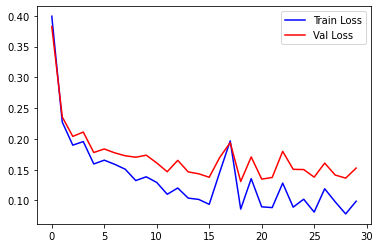

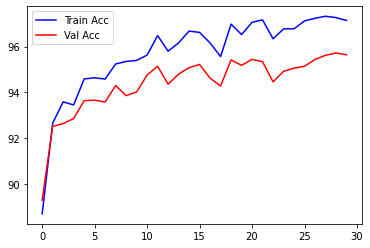

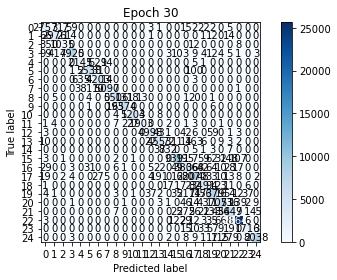

In [31]:
execute_training(
    num_epochs=num_epochs,
    model=resnet,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    trainloader=train_loader,
    valloader=val_loader,
    num_classes=num_classes,
    batch_size=batch_size,
    train_set=train_set,
    val_set=val_set,
    plot_loss=True,
    plot_accuracy=True,
    plot_confusion_matrix=True,
)

In [32]:
file='resnet152.pth'

In [35]:
torch.save(resnet.state_dict(),file)

In [38]:
loaded_model= models.resnet152(pretrained=True)

In [39]:
for param in loaded_model.parameters():
    param.requires_grad=False

In [40]:
in_features=loaded_model.fc.in_features
loaded_model.fc=nn.Sequential(nn.Linear(in_features,64),
                        torch.nn.Dropout(0.25),
                        nn.LeakyReLU(),
                        nn.Linear(64,25)
                       )

In [41]:
loaded_model.load_state_dict(torch.load(file))
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
loaded_model=loaded_model.to(device)

In [43]:
evaluation(test_loader,loaded_model)

95.81803671189147

In [44]:
out=loaded_model(images.to(device))
print(out.shape)

torch.Size([8, 25])


In [49]:
def predict(img_path,model,device,):
    from PIL import Image
    import torch.nn.functional as F
    img1=Image.open(img_path)
    img1_trans=transform_test(img1)
    img1_trans_reshaped=img1_trans.view(-1,3,224,224)
    out=model(img1_trans_reshaped.to(device))
    out_softmax=F.softmax(out,1)
    max_val,pred=torch.max(out_softmax.data,1)
    classes=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
         'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight',
         'Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
         'Potato___Early_blight','Potato___healthy','Potato___Late_blight','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___healthy','Tomato___Late_blight',
         'Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot',
         'Tomato___Tomato_mosaic_virus','Tomato___Tomato_Yellow_Leaf_Curl_Virus']
    prediction=classes[pred.data.item()]
    title=prediction
    img1_array=np.array(img1)
    plt.figure(facecolor='white')
    plt.imshow(img1_array)
    plt.axis('off')
    plt.title(title,fontdict={'fontsize':12})
    plt.show()

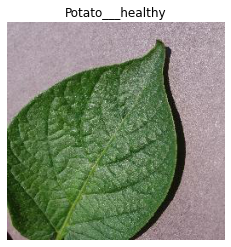

In [50]:
img_path='1.jpg'
predict(img_path,loaded_model,device)